### Competition description

Rohlik Group, a leading European e-grocery innovator, is revolutionising the food retail industry. We operate across 11 warehouses in Czech Republic, Germany, Austria, Hungary, and Romania.

Our challenge focuses on predicting the number of orders (grocery deliveries) at selected warehouses for the next 60 days.

### Columns

train.csv

    warehouse - warehouse name
    date - date
    orders - number of customer orders attributed to the warehouse
    holiday_name - name of public holiday if any
    holiday - 0/1 indicating the presence of holidays
    shutdown - warehouse shutdown or limitation due to operations (not provided in test)
    mini_shutdown - warehouse shutdown or limitation due to operations (not provided in test)
    shops_closed - public holiday with most of the shops or large part of shops closed
    winter_school_holidays - school holidays
    school_holidays - school holidays
    blackout - warehouse shutdown or limitation due to operations (not provided in test)
    mov_change - a change in minimum order value indicating potential change in customer behaviour (not provided in test)
    frankfurt_shutdown - warehouse shutdown or limitation due to operations (not provided in test)
    precipitation - precipitation in mm around the location of the warehouse which correlates with location of the customers (not provided in test)
    snow - snowfall in mm around the location of the warehouse which correlates with location of the customers (not provided in test)
    user_activity_1 - user activity on the website (not provided in test)
    user_activity_2 - user activity on the website (not provided in test)
    id - row id consisting of warehouse name and date

train_calendar.csv
    
    Contains a subset of the train.csv columns but more rows as it contains all dates whereas train.csv does not contain dates where warehouse was closed due to public holidays or other events

### Libraries loading 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\LiangX\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

### Data loading

In [4]:
# C:\Users\LiangX\Desktop\Kaggle\rohlik-orders-forecasting-challenge
df_train = pd.read_csv('C:\\Users\\LiangX\\Desktop\\Kaggle\\rohlik-orders-forecasting-challenge\\train.csv')

df_train.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   warehouse               7340 non-null   object 
 1   date                    7340 non-null   object 
 2   orders                  7340 non-null   float64
 3   holiday_name            218 non-null    object 
 4   holiday                 7340 non-null   int64  
 5   shutdown                7340 non-null   int64  
 6   mini_shutdown           7340 non-null   int64  
 7   shops_closed            7340 non-null   int64  
 8   winter_school_holidays  7340 non-null   int64  
 9   school_holidays         7340 non-null   int64  
 10  blackout                7340 non-null   int64  
 11  mov_change              7340 non-null   float64
 12  frankfurt_shutdown      7340 non-null   int64  
 13  precipitation           7070 non-null   float64
 14  snow                    7070 non-null   

In [6]:
df_train.isna().sum()

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shutdown                     0
mini_shutdown                0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
blackout                     0
mov_change                   0
frankfurt_shutdown           0
precipitation              270
snow                       270
user_activity_1              0
user_activity_2              0
id                           0
dtype: int64

### Data processing

In [7]:
# drop id non-sense column
df_train_cleaned = df_train.drop(['id', 'holiday_name'], axis=1)
df_train_cleaned = df_train_cleaned.dropna()
df_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7070 entries, 0 to 7339
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   warehouse               7070 non-null   object 
 1   date                    7070 non-null   object 
 2   orders                  7070 non-null   float64
 3   holiday                 7070 non-null   int64  
 4   shutdown                7070 non-null   int64  
 5   mini_shutdown           7070 non-null   int64  
 6   shops_closed            7070 non-null   int64  
 7   winter_school_holidays  7070 non-null   int64  
 8   school_holidays         7070 non-null   int64  
 9   blackout                7070 non-null   int64  
 10  mov_change              7070 non-null   float64
 11  frankfurt_shutdown      7070 non-null   int64  
 12  precipitation           7070 non-null   float64
 13  snow                    7070 non-null   float64
 14  user_activity_1         7070 non-null   float

In [8]:
df_train_cleaned['date'] = pd.to_datetime(df_train_cleaned['date'])

df_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7070 entries, 0 to 7339
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   warehouse               7070 non-null   object        
 1   date                    7070 non-null   datetime64[ns]
 2   orders                  7070 non-null   float64       
 3   holiday                 7070 non-null   int64         
 4   shutdown                7070 non-null   int64         
 5   mini_shutdown           7070 non-null   int64         
 6   shops_closed            7070 non-null   int64         
 7   winter_school_holidays  7070 non-null   int64         
 8   school_holidays         7070 non-null   int64         
 9   blackout                7070 non-null   int64         
 10  mov_change              7070 non-null   float64       
 11  frankfurt_shutdown      7070 non-null   int64         
 12  precipitation           7070 non-null   float64      

In [9]:
# There are 7 different warehouses in total
df_train_cleaned['warehouse'].value_counts()

warehouse
Brno_1         1193
Prague_1       1192
Prague_2       1192
Budapest_1     1151
Prague_3        931
Munich_1        785
Frankfurt_1     626
Name: count, dtype: int64

In [10]:
# take a glance at all numerical columns
round(df_train_cleaned.describe(), 2)

,date,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2
count,7070,7070.00,7070.00,7070.00,7070.00,7070.00,7070.00,7070.00,7070.00,7070.00,7070.00,7070.00,7070.00,7070.00,7070.00
mean,2022-09-15 09:55:08.741159936,5585.31,0.03,0.00,0.00,0.01,0.03,0.01,0.00,0.23,0.00,1.62,0.29,1658.02,23702.26
min,2020-12-05 00:00:00,790.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,482.00,1797.00
25%,2021-12-28 00:00:00,4500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,946.00,18834.25
50%,2022-09-28 00:00:00,5460.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1571.50,22463.50
75%,2023-06-23 00:00:00,7064.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,2314.00,30421.50
max,2024-03-15 00:00:00,18139.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,80.00,19.84,3437.00,45769.00
std,NaN,2205.43,0.16,0.01,0.02,0.10,0.17,0.09,0.03,0.42,0.02,4.54,1.55,787.63,9019.80


In [11]:
df_train_holiday = df_train_cleaned[df_train_cleaned['holiday'] == 1]

df_train_holiday.head(10)

,warehouse,date,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2
19,Prague_1,2020-12-24,4327.0,1,0,0,0,0,0,0,0.0,0,0.2,0.0,1652.0,32332.0
20,Prague_1,2020-12-26,7784.0,1,0,0,1,0,0,0,0.0,0,0.0,0.0,1867.0,31922.0
26,Prague_1,2021-01-01,3754.0,1,0,0,1,0,0,0,0.0,0,0.0,0.0,1618.0,31352.0
117,Prague_1,2021-04-02,9224.0,1,0,0,0,0,0,0,0.0,0,0.0,0.0,1747.0,35186.0
118,Prague_1,2021-04-03,8491.0,1,0,0,0,0,0,0,0.0,0,0.0,0.0,1762.0,35256.0
119,Prague_1,2021-04-04,7664.0,1,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,35264.0
120,Prague_1,2021-04-05,6936.0,1,0,0,1,0,0,0,0.0,0,0.0,0.0,1762.0,35283.0
146,Prague_1,2021-05-01,7627.0,1,0,0,0,0,0,0,0.0,0,11.9,0.0,1660.0,33968.0
153,Prague_1,2021-05-08,8215.0,1,0,0,1,0,0,0,0.0,0,0.0,0.0,1708.0,33325.0
211,Prague_1,2021-07-05,5796.0,1,0,0,0,0,0,0,0.0,0,0.0,0.0,1627.0,32000.0


    date column will be used for applying time series prediction and visualization
    
    see if different warehouses are different from each other, if not, we can drop warehouse column

### Charts

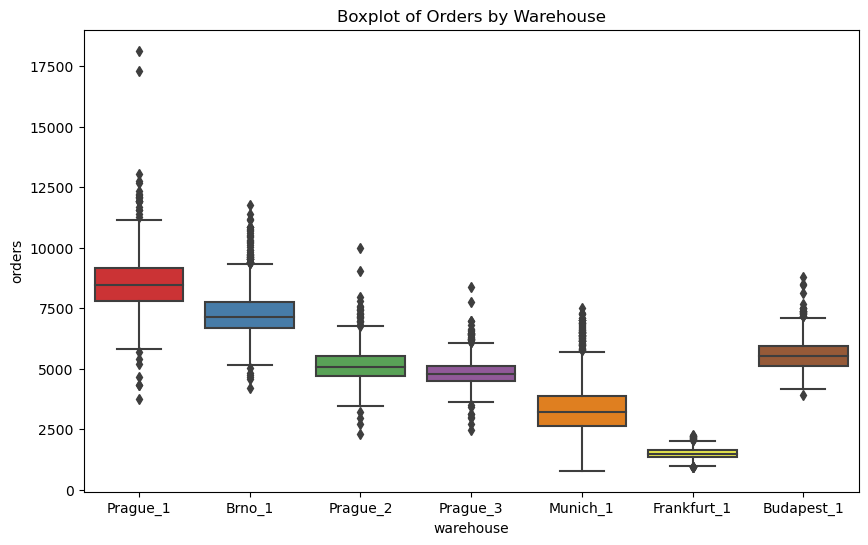

In [12]:
# To see if different warehouses have different parttens and distributions of orders 
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='warehouse', y='orders', data=df_train_cleaned, palette='Set1')

# Show the plot
plt.title('Boxplot of Orders by Warehouse')
plt.show()

C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a

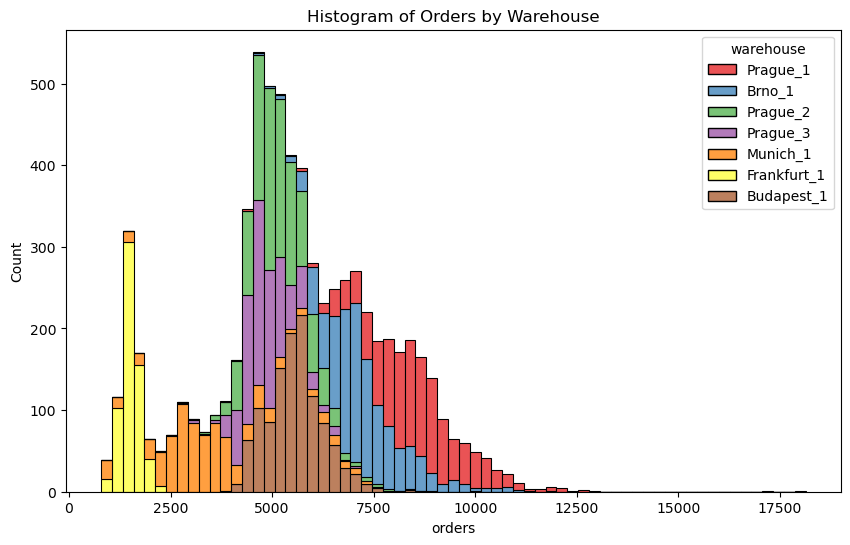

In [13]:
# Create a histogram with hue
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train_cleaned, x='orders', hue='warehouse', multiple='stack', palette='Set1')

# Show the plot
plt.title('Histogram of Orders by Warehouse')
plt.show()

C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

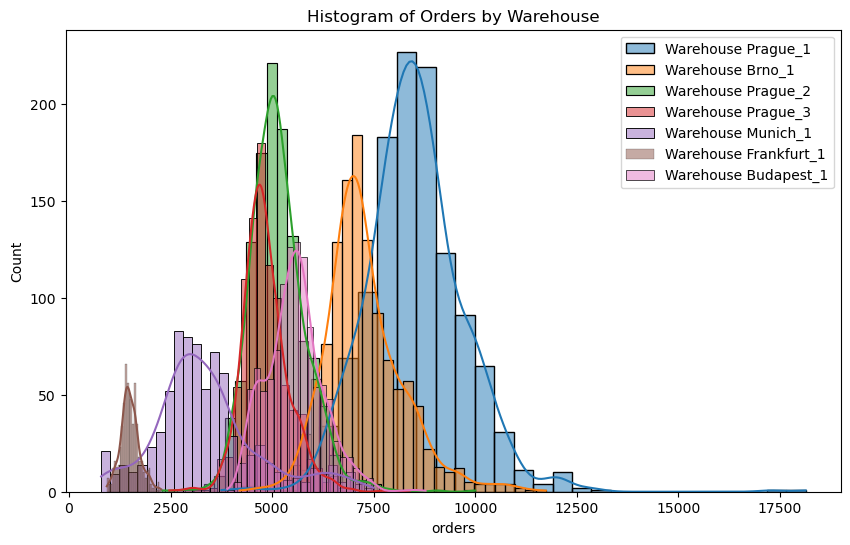

In [14]:
# Get the unique warehouse values
warehouses = df_train_cleaned['warehouse'].unique()

# Create a histogram for each warehouse
plt.figure(figsize=(10, 6))
for warehouse in warehouses:
    sns.histplot(data=df_train_cleaned[df_train_cleaned['warehouse'] == warehouse], x='orders', label=f'Warehouse {warehouse}', kde=True, bins=30)

# Add title and legend
plt.title('Histogram of Orders by Warehouse')
plt.legend()
plt.show()

    only Prague 2 and 3 are similar to each other but still all warehouses are different

C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a le

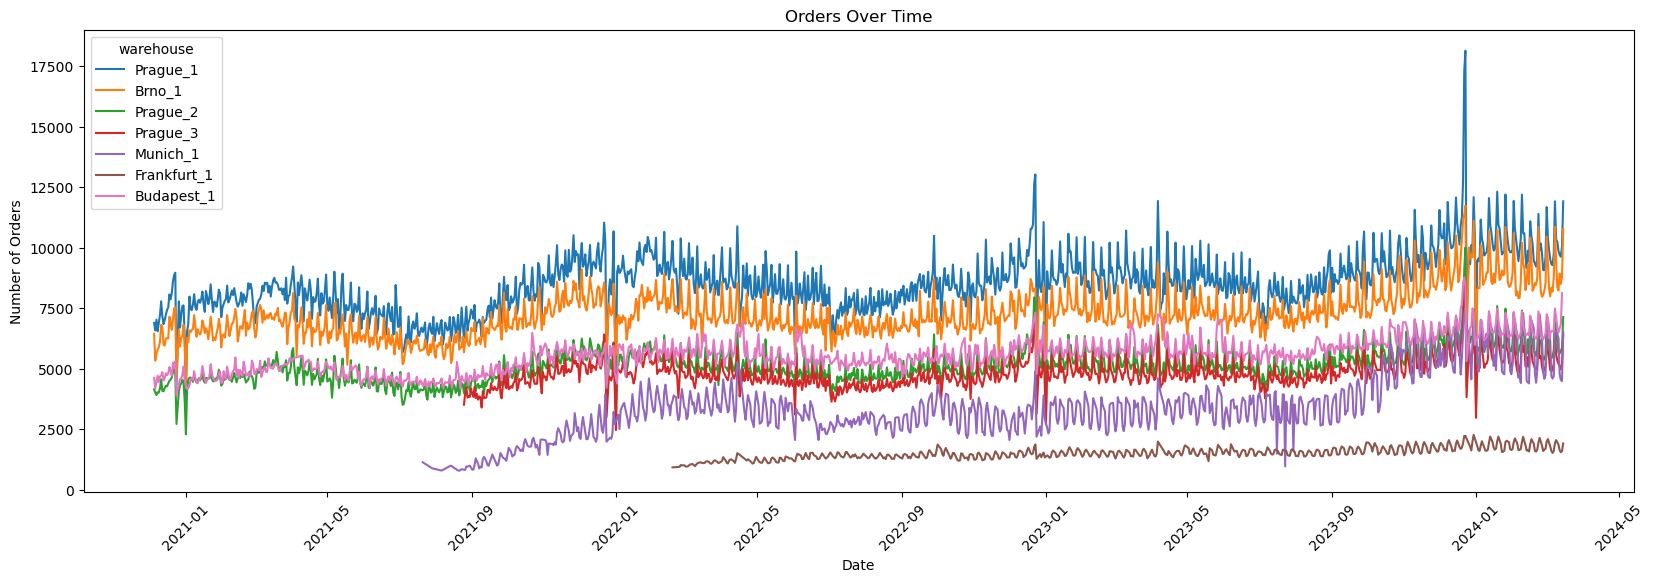

In [15]:
# Line chart to see how orders amount flustuate over dates
# Create a line chart
plt.figure(figsize=(20, 6))
sns.lineplot(x='date', y='orders', data=df_train_cleaned, hue='warehouse')

# Add title and labels
plt.title('Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')

# Show the plot
plt.xticks(rotation=45)
plt.show()

C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


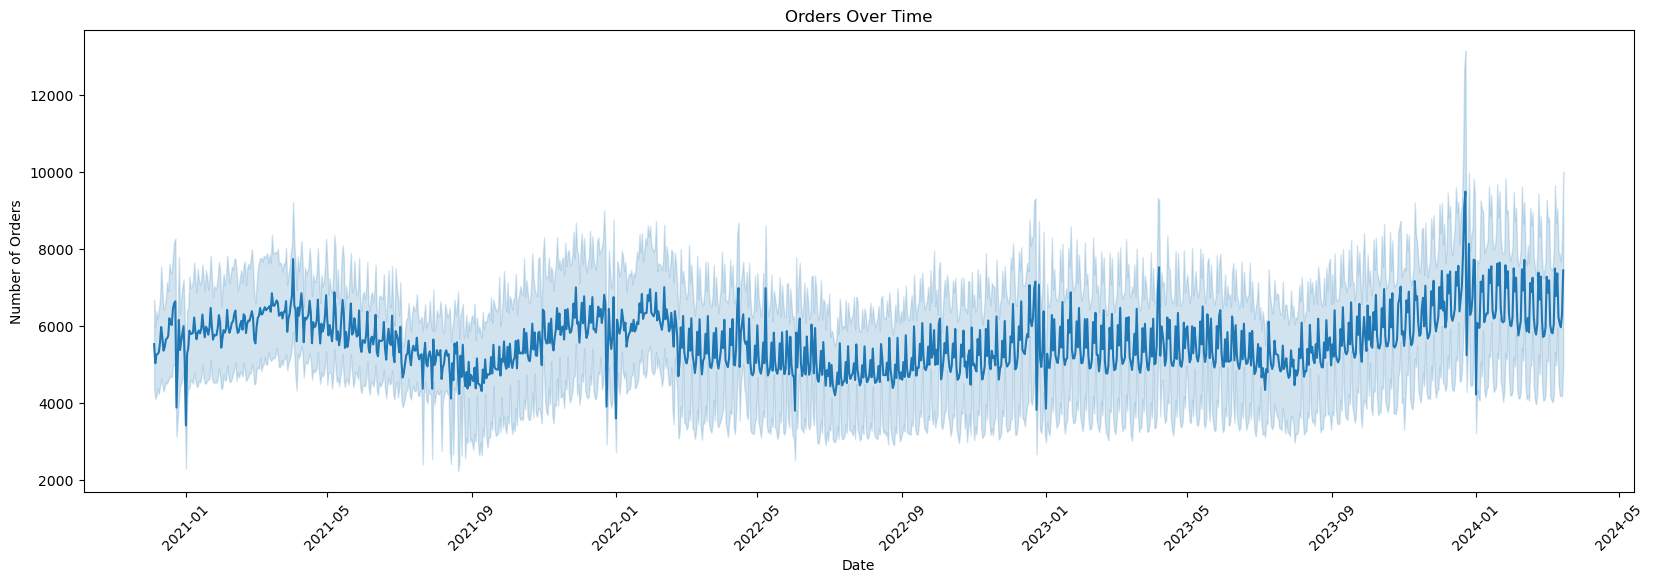

In [16]:
# Create a line chart
plt.figure(figsize=(20, 6))
sns.lineplot(x='date', y='orders', data=df_train_cleaned)

# Add title and labels
plt.title('Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')

# Show the plot
plt.xticks(rotation=45)
plt.show()

    7 warehouses should have 7 different prediction models 

In [17]:
# check out the relationships between user_activity_1 and orders / user_activity_2 and orders / user_activity_1 and user_activity_2
# Scatter plot


###  train_calendar Data inspection

In [18]:
# C:\Users\LiangX\Desktop\Kaggle\rohlik-orders-forecasting-challenge
df_train_calendar = pd.read_csv('C:\\Users\\LiangX\\Desktop\\Kaggle\\rohlik-orders-forecasting-challenge\\train_calendar.csv')

df_train_calendar.head()

,date,holiday_name,holiday,shutdown,mini_shutdown,warehouse_limited,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,warehouse
0,2022-03-09,NaN,0,0,0,0,0,1,0,0,0.0,0,0.0,0.0,Prague_1
1,2019-07-03,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
2,2020-05-18,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
3,2021-11-09,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
4,2023-08-02,NaN,0,0,0,0,0,0,0,0,0.0,0,2.5,0.0,Prague_1


In [19]:
df_train_calendar['date'] = pd.to_datetime(df_train_calendar['date'])
df_train_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307 entries, 0 to 13306
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    13307 non-null  datetime64[ns]
 1   holiday_name            563 non-null    object        
 2   holiday                 13307 non-null  int64         
 3   shutdown                13307 non-null  int64         
 4   mini_shutdown           13307 non-null  int64         
 5   warehouse_limited       13307 non-null  int64         
 6   shops_closed            13307 non-null  int64         
 7   winter_school_holidays  13307 non-null  int64         
 8   school_holidays         13307 non-null  int64         
 9   blackout                13307 non-null  int64         
 10  mov_change              13307 non-null  float64       
 11  frankfurt_shutdown      13307 non-null  int64         
 12  precipitation           11199 non-null  float6

In [20]:
df_train_calendar.describe()

,date,holiday,shutdown,mini_shutdown,warehouse_limited,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow
count,13307,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,13307.000000,11199.000000,11199.000000
mean,2021-08-08 00:00:00,0.041632,0.001278,0.000601,0.002480,0.026227,0.018411,0.005486,0.000526,0.129834,0.000225,1.430748,0.212475
min,2019-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2020-04-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2021-08-08 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2022-11-26 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.670000,0.000000
max,2024-03-15 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,19.840000
std,NaN,0.199755,0.035721,0.024513,0.049739,0.159815,0.134439,0.073866,0.022930,0.332569,0.015014,4.252921,1.323071


In [21]:
# description says calendar data has all dates while train data has not shut down dates, here is to check this fact
# Create a complete date range for January 2023
start_date = '2020-12-05'
end_date = '2024-03-15'
complete_date_range = pd.date_range(start=start_date, end=end_date)

# Find missing dates
missing_dates = complete_date_range.difference(df_train_calendar['date'])

# Print missing dates
print("Missing dates in the range:")
print(missing_dates)

Missing dates in the range:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [22]:
# Create a complete date range for January 2023
start_date = '2020-12-05'
end_date = '2024-03-15'
complete_date_range = pd.date_range(start=start_date, end=end_date)

# Find missing dates
missing_dates = complete_date_range.difference(df_train_cleaned['date'])

# Print missing dates
print("Missing dates in the range:")
print(missing_dates)

Missing dates in the range:
DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)


    looks like train data only is missing 12/25 date of each year. for prediction of the next 60 days, it is not a problem

### Data processing 2

In [23]:
# create dummy variable for "warehouse" column
df_processed = pd.get_dummies(df_train_cleaned, columns=['warehouse'], drop_first=True, dtype=int)
df_processed.head()

,date,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,...,precipitation,snow,user_activity_1,user_activity_2,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3
0,2020-12-05,6895.0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,1722.0,32575.0,0,0,0,1,0,0
1,2020-12-06,6584.0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,1688.0,32507.0,0,0,0,1,0,0
2,2020-12-07,7030.0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,1696.0,32552.0,0,0,0,1,0,0
3,2020-12-08,6550.0,0,0,0,0,0,0,0,0.0,...,0.8,0.0,1681.0,32423.0,0,0,0,1,0,0
4,2020-12-09,6910.0,0,0,0,0,0,0,0,0.0,...,0.5,0.0,1704.0,32410.0,0,0,0,1,0,0


In [24]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7070 entries, 0 to 7339
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    7070 non-null   datetime64[ns]
 1   orders                  7070 non-null   float64       
 2   holiday                 7070 non-null   int64         
 3   shutdown                7070 non-null   int64         
 4   mini_shutdown           7070 non-null   int64         
 5   shops_closed            7070 non-null   int64         
 6   winter_school_holidays  7070 non-null   int64         
 7   school_holidays         7070 non-null   int64         
 8   blackout                7070 non-null   int64         
 9   mov_change              7070 non-null   float64       
 10  frankfurt_shutdown      7070 non-null   int64         
 11  precipitation           7070 non-null   float64       
 12  snow                    7070 non-null   float64      

In [25]:
df_processed.isna().sum()

date                      0
orders                    0
holiday                   0
shutdown                  0
mini_shutdown             0
shops_closed              0
winter_school_holidays    0
school_holidays           0
blackout                  0
mov_change                0
frankfurt_shutdown        0
precipitation             0
snow                      0
user_activity_1           0
user_activity_2           0
warehouse_Budapest_1      0
warehouse_Frankfurt_1     0
warehouse_Munich_1        0
warehouse_Prague_1        0
warehouse_Prague_2        0
warehouse_Prague_3        0
dtype: int64

In [26]:
df_processed = df_processed.dropna()

In [27]:
df_processed.isna().sum()

date                      0
orders                    0
holiday                   0
shutdown                  0
mini_shutdown             0
shops_closed              0
winter_school_holidays    0
school_holidays           0
blackout                  0
mov_change                0
frankfurt_shutdown        0
precipitation             0
snow                      0
user_activity_1           0
user_activity_2           0
warehouse_Budapest_1      0
warehouse_Frankfurt_1     0
warehouse_Munich_1        0
warehouse_Prague_1        0
warehouse_Prague_2        0
warehouse_Prague_3        0
dtype: int64

### Modeling

In [28]:
pd.set_option('display.max_columns', None)
df_processed.head()

,date,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3
0,2020-12-05,6895.0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,0,0,0,1,0,0
1,2020-12-06,6584.0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,0,0,0,1,0,0
2,2020-12-07,7030.0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,0,0,0,1,0,0
3,2020-12-08,6550.0,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,0,0,0,1,0,0
4,2020-12-09,6910.0,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,0,0,0,1,0,0


In [29]:
df_processed.columns

Index(['date', 'orders', 'holiday', 'shutdown', 'mini_shutdown',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout',
       'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow',
       'user_activity_1', 'user_activity_2', 'warehouse_Budapest_1',
       'warehouse_Frankfurt_1', 'warehouse_Munich_1', 'warehouse_Prague_1',
       'warehouse_Prague_2', 'warehouse_Prague_3'],
      dtype='object')

In [30]:
# split the data 
X = df_processed[['holiday', 'shutdown', 'mini_shutdown',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout',
       'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow',
       'user_activity_1', 'user_activity_2', 'warehouse_Budapest_1',
       'warehouse_Frankfurt_1', 'warehouse_Munich_1', 'warehouse_Prague_1',
       'warehouse_Prague_2', 'warehouse_Prague_3']]  
y = df_processed['orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [32]:
y_pred = model.predict(X_test)

In [33]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Testing Set Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Testing Set Metrics:
Mean Squared Error: 338975.75815506885
R-squared: 0.9324033368928706


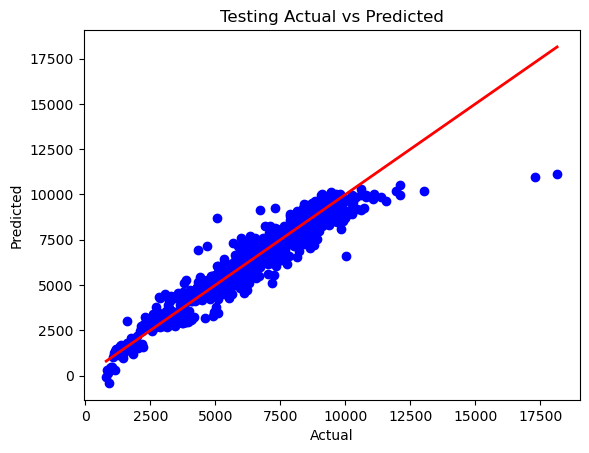

In [34]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Actual vs Predicted')
plt.show()


In [35]:
# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Calculate Mean Squared Error (MSE) and R-squared (R2) for training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"Training Set Metrics:")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"R-squared (R2): {r2_train}")

Training Set Metrics:
Mean Squared Error (MSE): 247730.33626626438
R-squared (R2): 0.9486582129301926


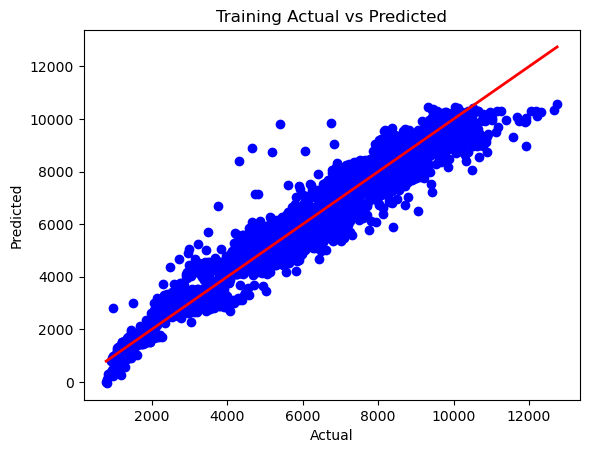

In [36]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.scatter(y_train, y_train_pred, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linewidth=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Actual vs Predicted')
plt.show()


### Data processing 3

In [37]:
# remove extreme outliers
# orders in a date over 15000 is a outlier
df_processed = df_processed[df_processed['orders'] <= 15000]
df_processed.describe()

,date,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3
count,7068,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.00000
mean,2022-09-15 06:46:27.096774400,5581.875071,0.026740,0.000141,0.000566,0.010753,0.030136,0.007357,0.000990,0.230023,0.000283,1.617949,0.289911,1657.957697,23696.119411,0.162847,0.088568,0.111064,0.168364,0.168647,0.13172
min,2020-12-05 00:00:00,790.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,482.000000,1797.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2021-12-28 00:00:00,4499.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,946.000000,18833.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,2022-09-28 00:00:00,5459.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1499.500000,22463.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,2023-06-23 00:00:00,7064.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2314.000000,30406.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,2024-03-15 00:00:00,13028.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,19.840000,3437.000000,45625.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
std,NaN,2196.276603,0.161335,0.011895,0.023784,0.103143,0.170973,0.085463,0.031457,0.415762,0.016820,4.539102,1.546183,787.731286,9013.674306,0.369252,0.284140,0.314234,0.374216,0.374467,0.33821


### Modeling 2

In [38]:
# split the data 
X = df_processed[['holiday', 'shutdown', 'mini_shutdown',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout',
       'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow',
       'user_activity_1', 'user_activity_2', 'warehouse_Budapest_1',
       'warehouse_Frankfurt_1', 'warehouse_Munich_1', 'warehouse_Prague_1',
       'warehouse_Prague_2', 'warehouse_Prague_3']]  
y = df_processed['orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# modeling training
model2 = LinearRegression()
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Testing Set Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Make predictions on the training set
y_train_pred = model2.predict(X_train)

# Calculate Mean Squared Error (MSE) and R-squared (R2) for training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print("\n")
print(f"Training Set Metrics:")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"R-squared (R2): {r2_train}")

Testing Set Metrics:
Mean Squared Error: 276300.2872319872
R-squared: 0.9420605256089001


Training Set Metrics:
Mean Squared Error (MSE): 248546.17555586857
R-squared (R2): 0.9486100860948976


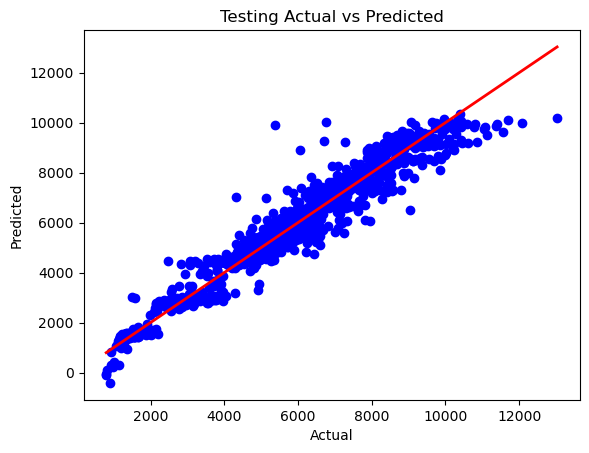

In [39]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Actual vs Predicted')
plt.show()

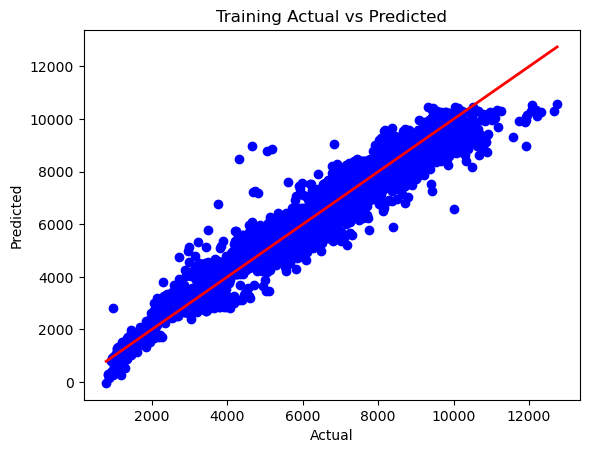

In [40]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.scatter(y_train, y_train_pred, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linewidth=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Actual vs Predicted')
plt.show()


In [41]:
# Assuming y_test and y_pred are your actual and predicted values, respectively
y_test = np.array(y_test)  # Convert y_test and y_pred to numpy arrays for calculation
y_pred = np.array(y_pred)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test))

print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Percentage Error (MAPE): 0.07309680442547005


    MAPE should be as low as 0.3 

### Time series modeling

In [42]:
# There are 7 different warehouses in total
df_train_cleaned['warehouse'].value_counts()

warehouse
Brno_1         1193
Prague_1       1192
Prague_2       1192
Budapest_1     1151
Prague_3        931
Munich_1        785
Frankfurt_1     626
Name: count, dtype: int64

In [43]:
# separate warehouse first 
df_Brno_1  = df_train_cleaned[df_train_cleaned['warehouse'] == 'Brno_1']
df_Brno_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1193 entries, 1193 to 2385
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   warehouse               1193 non-null   object        
 1   date                    1193 non-null   datetime64[ns]
 2   orders                  1193 non-null   float64       
 3   holiday                 1193 non-null   int64         
 4   shutdown                1193 non-null   int64         
 5   mini_shutdown           1193 non-null   int64         
 6   shops_closed            1193 non-null   int64         
 7   winter_school_holidays  1193 non-null   int64         
 8   school_holidays         1193 non-null   int64         
 9   blackout                1193 non-null   int64         
 10  mov_change              1193 non-null   float64       
 11  frankfurt_shutdown      1193 non-null   int64         
 12  precipitation           1193 non-null   float64   

In [44]:
date_rng = df_Brno_1['date']
data = df_Brno_1['orders']
df = pd.DataFrame({'date': date_rng, 'orders': data})

# Set 'date' column as the index
df.set_index('date', inplace=True)

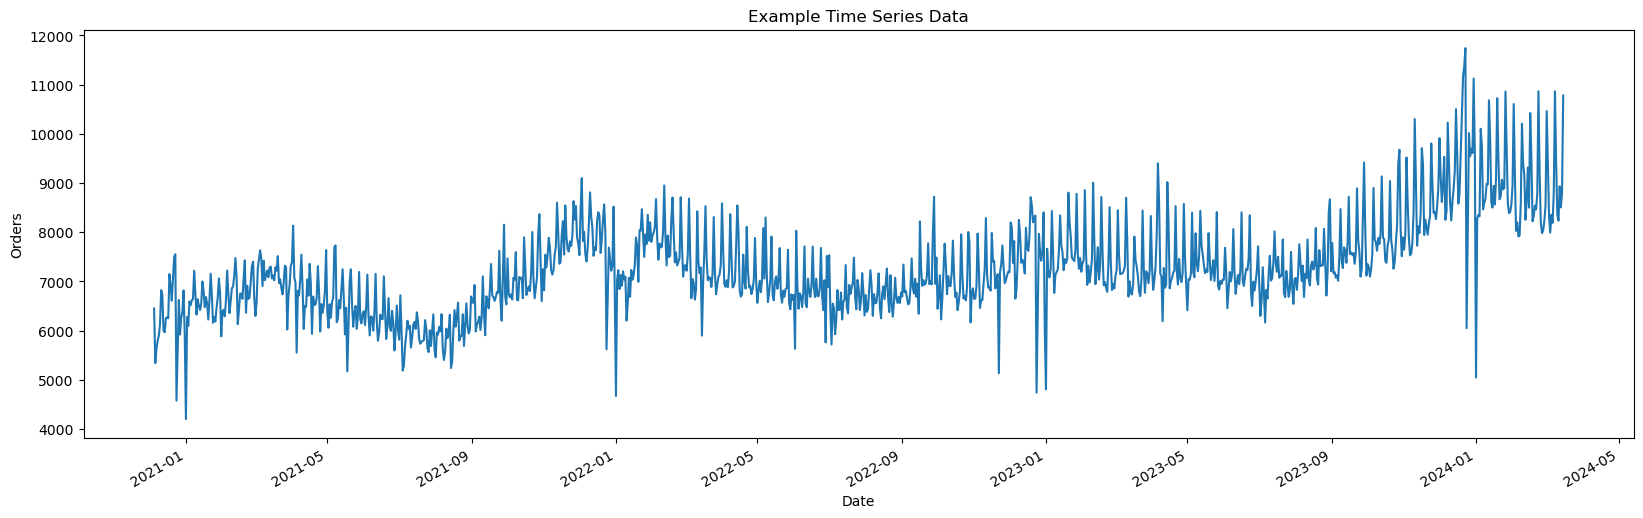

In [45]:
# Plotting the time series
plt.figure(figsize=(20, 6))
df['orders'].plot()
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Example Time Series Data')
plt.show()

In [46]:
# Use auto_arima to automatically select the best ARIMA model
model = auto_arima(df['orders'], seasonal=False, trace=True)   # m is to define seasonal period length 

# Print model summary
print(model.summary())

# Forecasting (example: forecasting the next 10 periods)
forecast = model.predict(n_periods=60)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18585.704, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19104.529, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19022.411, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18681.193, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19102.559, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18588.015, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18574.942, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18625.282, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=18874.920, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=18572.126, Time=0.97 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=18833.787, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=18528.863, Time=1.44 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=18795.051, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=18388.959, Time=1.38 sec
 ARIMA(5,1,0)(0,0,0

C:\Users\LiangX\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


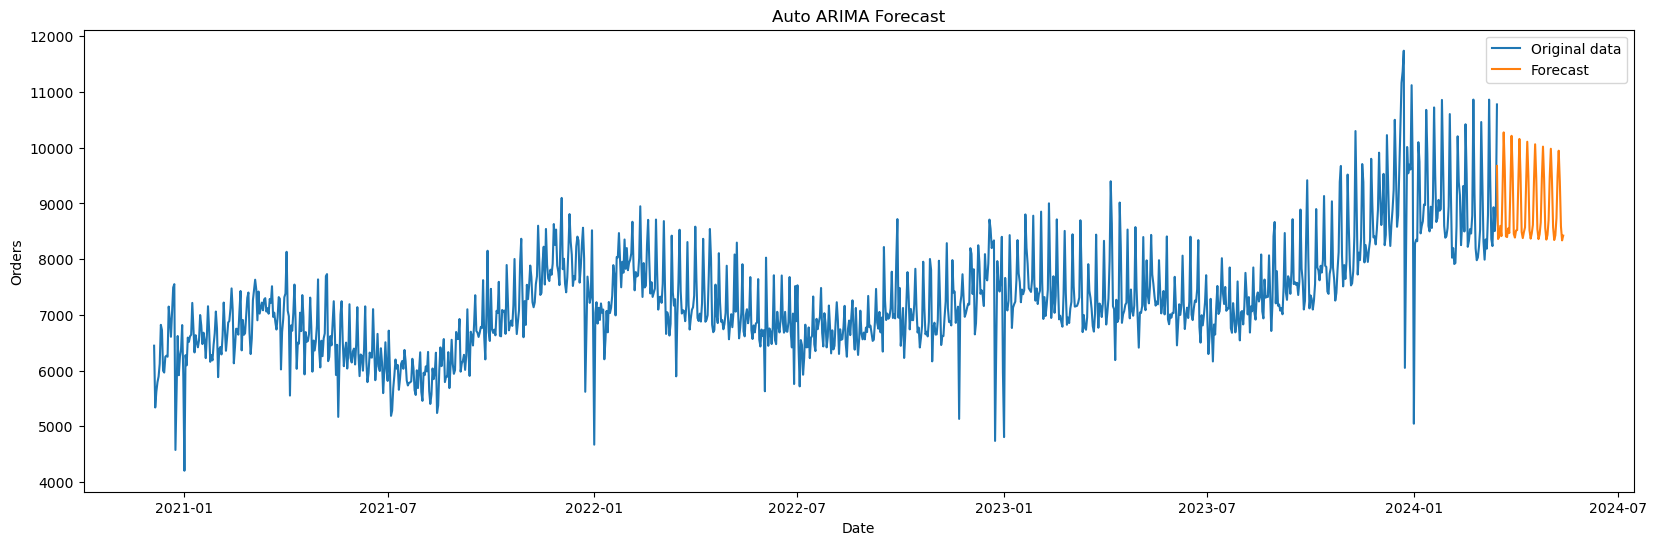

In [47]:
# Plotting forecasts
plt.figure(figsize=(20, 6))
plt.plot(df['orders'], label='Original data')
plt.plot(pd.date_range(start=df.index[-1], periods=60, freq='D'), forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Auto ARIMA Forecast')
plt.legend()
plt.show()

### Other models 

#### Polynomial Regression

In [48]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

# split the data 
X = df_processed[['holiday', 'shutdown', 'mini_shutdown',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout',
       'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow',
       'user_activity_1', 'user_activity_2', 'warehouse_Budapest_1',
       'warehouse_Frankfurt_1', 'warehouse_Munich_1', 'warehouse_Prague_1',
       'warehouse_Prague_2', 'warehouse_Prague_3']]  
y = df_processed['orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform input data
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

# Fit the model
model = LinearRegression()
model.fit(X_poly, y_train)

# Predict
X_test_poly = poly.transform(X_test)
y_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Testing Set Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

y_test = np.array(y_test)  # Convert y_test and y_pred to numpy arrays for calculation
y_pred = np.array(y_pred)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test))

print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Testing Set Metrics:
Mean Squared Error: 239326.9615529472
R-squared: 0.9498137388892608
Mean Absolute Percentage Error (MAPE): 0.06932325889433633


In [49]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

# split the data 
X = df_processed[['holiday', 'shutdown', 'mini_shutdown',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout',
       'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow',
       'user_activity_1', 'user_activity_2', 'warehouse_Budapest_1',
       'warehouse_Frankfurt_1', 'warehouse_Munich_1', 'warehouse_Prague_1',
       'warehouse_Prague_2', 'warehouse_Prague_3']]  
y = df_processed['orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform input data
poly = PolynomialFeatures(degree=3)     # degree is meaning x^n in the formula testing different degree to compare the results
X_poly = poly.fit_transform(X_train) 

# Fit the model
model = LinearRegression()
model.fit(X_poly, y_train)

# Predict
X_test_poly = poly.transform(X_test)
y_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Testing Set Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

y_test = np.array(y_test)  # Convert y_test and y_pred to numpy arrays for calculation
y_pred = np.array(y_pred)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test))

print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Testing Set Metrics:
Mean Squared Error: 254785.08830088988
R-squared: 0.9465722086403443
Mean Absolute Percentage Error (MAPE): 0.06795148434890766


#### Support Vector Machines (SVM)

In [50]:
# from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.svm import SVR
# #from sklearn.datasets import load_boston
# from sklearn.preprocessing import StandardScaler

# # split the data 
# X = df_processed[['holiday', 'shutdown', 'mini_shutdown',
#        'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout',
#        'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow',
#        'user_activity_1', 'user_activity_2', 'warehouse_Budapest_1',
#        'warehouse_Frankfurt_1', 'warehouse_Munich_1', 'warehouse_Prague_1',
#        'warehouse_Prague_2', 'warehouse_Prague_3']]  
# y = df_processed['orders']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define SVR model
# svr = SVR()

# # Define parameter grid with multiple kernels
# param_grid = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'C': [0.1, 1, 10],  # Regularization parameter
#     'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
#     'degree': [2, 3, 4],  # Degree of the polynomial kernel
#     'coef0': [0.0, 0.1, 0.5]  # Independent term in kernel function
# }

# # Perform nested cross-validation with grid search
# grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
#                            scoring='neg_mean_squared_error', verbose=1)
# grid_search.fit(X_train, y_train)

# # Print best parameters and best score
# print("Best parameters found:", grid_search.best_params_)
# print("Best negative mean squared error found:", grid_search.best_score_)

In [51]:
from sklearn.svm import SVR

# split the data 
X = df_processed[['holiday', 'shutdown', 'mini_shutdown',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout',
       'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow',
       'user_activity_1', 'user_activity_2', 'warehouse_Budapest_1',
       'warehouse_Frankfurt_1', 'warehouse_Munich_1', 'warehouse_Prague_1',
       'warehouse_Prague_2', 'warehouse_Prague_3']]  
y = df_processed['orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = SVR(kernel='linear')  # Radial Basis Function (RBF) kernel for non-linear SVM
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Testing Set Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

y_test = np.array(y_test)  # Convert y_test and y_pred to numpy arrays for calculation
y_pred = np.array(y_pred)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test))

print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Testing Set Metrics:
Mean Squared Error: 350249.6285051354
R-squared: 0.9265535349797631
Mean Absolute Percentage Error (MAPE): 0.08098950884517442


#### K-Nearest Neighbors (KNN)

In [52]:
from sklearn.neighbors import KNeighborsRegressor

# split the data 
X = df_processed[['holiday', 'shutdown', 'mini_shutdown',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout',
       'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow',
       'user_activity_1', 'user_activity_2', 'warehouse_Budapest_1',
       'warehouse_Frankfurt_1', 'warehouse_Munich_1', 'warehouse_Prague_1',
       'warehouse_Prague_2', 'warehouse_Prague_3']]  
y = df_processed['orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = KNeighborsRegressor(n_neighbors=12)  # You can adjust n_neighbors as needed
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Testing Set Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

y_test = np.array(y_test)  # Convert y_test and y_pred to numpy arrays for calculation
y_pred = np.array(y_pred)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test))

print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Testing Set Metrics:
Mean Squared Error: 325186.15133388335
R-squared: 0.9318092830220965
Mean Absolute Percentage Error (MAPE): 0.07310187151509728


#### Neural Networks (using TensorFlow/Keras)

In [53]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# # split the data 
# X = df_processed[['holiday', 'shutdown', 'mini_shutdown',
#        'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout',
#        'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow',
#        'user_activity_1', 'user_activity_2', 'warehouse_Budapest_1',
#        'warehouse_Frankfurt_1', 'warehouse_Munich_1', 'warehouse_Prague_1',
#        'warehouse_Prague_2', 'warehouse_Prague_3']]  
# y = df_processed['orders']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the model
# model = Sequential([
#     Dense(10, input_dim=1, activation='relu'),  # Hidden layer with ReLU activation
#     Dense(1)  # Output layer (single neuron for regression)
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Fit the model
# model.fit(X_train, y_train, epochs=1000, verbose=0)

# # Predict
# y_pred = model.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Testing Set Metrics:")
# print(f"Mean Squared Error: {mse}")
# print(f"R-squared: {r2}")

# y_test = np.array(y_test)  # Convert y_test and y_pred to numpy arrays for calculation
# y_pred = np.array(y_pred)

# # Calculate MAPE
# mape = np.mean(np.abs((y_test - y_pred) / y_test))

# print(f"Mean Absolute Percentage Error (MAPE): {mape}")


#### Gradient Boosting Machines

In [54]:
# import xgboost as xgb

# # split the data 
# X = df_processed[['holiday', 'shutdown', 'mini_shutdown',
#        'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout',
#        'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow',
#        'user_activity_1', 'user_activity_2', 'warehouse_Budapest_1',
#        'warehouse_Frankfurt_1', 'warehouse_Munich_1', 'warehouse_Prague_1',
#        'warehouse_Prague_2', 'warehouse_Prague_3']]  
# y = df_processed['orders']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Transform data for XGBoost
# dtrain = xgb.DMatrix(X_train, label=y)

# # Parameters for XGBoost
# params = {'objective': 'reg:squarederror', 'verbosity': 0}

# # Train the model
# model = xgb.train(params, dtrain)

# # Predict
# dtest = xgb.DMatrix(X_test)
# y_pred = model.predict(dtest)

# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Testing Set Metrics:")
# print(f"Mean Squared Error: {mse}")
# print(f"R-squared: {r2}")

# y_test = np.array(y_test)  # Convert y_test and y_pred to numpy arrays for calculation
# y_pred = np.array(y_pred)

# # Calculate MAPE
# mape = np.mean(np.abs((y_test - y_pred) / y_test))

# print(f"Mean Absolute Percentage Error (MAPE): {mape}")


### Prediction deployment

In [56]:
# load the first 10M rows of data
test_data = pd.read_csv('C:\\Users\\LiangX\\Desktop\\Kaggle\\rohlik-orders-forecasting-challenge\\test.csv')
test_data.head()

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,3/16/2024,NaN,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,3/17/2024,NaN,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,3/18/2024,NaN,0,0,0,0,Prague_1_2024-03-18
3,Prague_1,3/19/2024,NaN,0,0,0,0,Prague_1_2024-03-19
4,Prague_1,3/20/2024,NaN,0,0,0,0,Prague_1_2024-03-20


In [57]:
# test_data['orders'] = model.predict(test_data)
# test_data.head()

In [ ]:
# output_data = test_data[['id', 'orders']]
# output_data

In [ ]:
# # Export DataFrame to CSV file
# output_data.to_csv('submission.csv', index=False)

    There is not enough data for the prediction model. We don't have user_activity_1 and user_activity_2 data for testing set. 